# Meeting
* Members skills presentation
## What area is covered by sugar cane?
* Clouds? -- SCL help (1 person)
* Preprocessing
* Clustering
   + [Overview different algorithms](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html)
   + [Performance evaluation](https://stats.stackexchange.com/questions/21807/evaluation-measures-of-goodness-or-validity-of-clustering-without-having-truth)
   + Performance in literature
* Time-depending ideas?
* Another approach?
* Expert (1 person)
* Time Series? (can be the expert)

In [16]:
import os
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import xarray
import datetime
import warnings

warnings.filterwarnings('ignore')

In [2]:
# read in the sentinel 2 data
s2_data = xarray.open_dataset('cali_training.nc')
s2_data

<xarray.Dataset>
Dimensions:      (band: 10, date: 26, x: 994, y: 940)
Coordinates:
  * band         (band) object 'B02' 'B03' 'B04' 'B05' ... 'B8A' 'B11' 'B12'
  * date         (date) datetime64[ns] 2016-12-18 2017-02-16 ... 2019-01-22
Dimensions without coordinates: x, y
Data variables:
    reflectance  (y, x, band, date) uint16 ...
    mask         (y, x) bool ...
    SCL          (y, x, date) uint16 ...
Attributes:
    transform:  [ 1.0000e+01  0.0000e+00  3.3092e+05  0.0000e+00 -1.0000e+01 ...
    crs:        +init=epsg:32618

In [3]:
band_dict = {k: v for v,k in enumerate(s2_data.band.values)}
date_dict = {str(k)[:10]: v for v,k in enumerate(s2_data.date.values)}

In [13]:
def image_histogram_equalization(image):
    """ Image histogram equlisation"""
    # from http://www.janeriksolem.net/2009/06/histogram-equalization-with-python-and.html

    # get image histogram
    image_histogram, bins = np.histogram(image.flatten(), 256, normed=True)
    cdf = image_histogram.cumsum() # cumulative distribution function
    cdf = (255-1) * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)
    
    if len(image.shape) == 3:
        return image_equalized.reshape(image.shape).astype('uint8')[:,:,::-1]
    else:
        return image_equalized.reshape(image.shape).astype('uint8')

In [7]:
w, h = s2_data.reflectance.isel(date=0, band=0).values.shape

def create_dataset(obj, d):
    try:
        l, = s2_data.band.values.shape
        return np.concatenate([obj.isel(date=d, band=b).values.reshape(w, h, 1) for b in range(l)], axis=-1)
    except:
        return obj.isel(date=d).values.reshape(w, h)

In [8]:
def add_feature(X, fea, ax=2):
    return np.concatenate((X, fea), axis=ax)

In [24]:
X_SCL_0 = create_dataset(s2_data.SCL, 0)

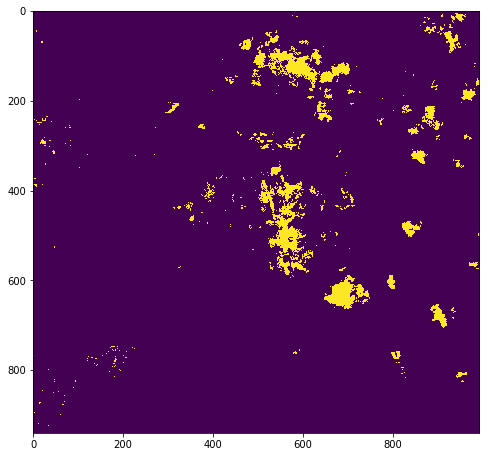

In [29]:
plt.figure(figsize=(8,8))
plt.imshow((X_SCL_0 == 9) | (X_SCL_0 == 8))
plt.show()


In [43]:
X_refl_0 = create_dataset(s2_data.reflectance, 1)/10000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


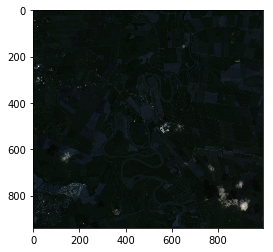

In [45]:
plt.imshow(X_refl_0[:,:,:3])

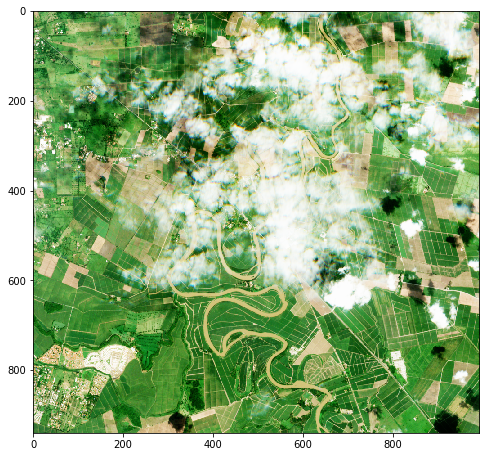

In [37]:
plt.figure(figsize=(8,8))
plt.imshow(image_histogram_equalization(X_refl_0[:,:,:3]))
plt.show()

In [46]:
r = X_refl_0[:,:,band_dict['B04']] 
ir = X_refl_0[:,:,band_dict['B08']]
add_feature(X_refl_0, ((ir-r)/(ir+r)).reshape(w, h, 1)).shape

(940, 994, 11)